In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


In [2]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self, layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.ReLU()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

            
    'foward pass'
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        a = x.float()
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a

In [3]:
def f(x):
    y= 25*x**3 - 5*torch.exp(1*x)
    return y


class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class super().__init__()
              
        'activation function'
        self.activation = nn.ReLU()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        'Initialize our new parameters i.e. 𝜆 (Inverse problem)' 
        self.lambda1 = torch.tensor([lambda1], requires_grad=True).float().to(device).clamp(23,28)
        self.lambda2 = torch.tensor([lambda2], requires_grad=True).float().to(device).clamp(-4,-6)
        self.lambda3 = torch.tensor([lambda3], requires_grad=True).float().to(device)
#         self.lambda4 = torch.tensor([lambda4], requires_grad=True).float().to(device)
#         self.lambda5 = torch.tensor([lambda5], requires_grad=True).float().to(device)
        
        'Register lambda to optimize'
        self.lambda1 = nn.Parameter(self.lambda1)
# self.lambda1 = nn.Parameter(self.lambda1.clamp(0.8,1.2))
        self.lambda2 = nn.Parameter(self.lambda2)
        self.lambda3 = nn.Parameter(self.lambda3)
#         self.lambda4 = nn.Parameter(self.lambda4)
#         self.lambda5 = nn.Parameter(self.lambda5)
        
        'Call our DNN'
        self.dnn = DNN(layers).to(device)
        'Register our new parameter'
        self.dnn.register_parameter('lambda1', self.lambda1)  
        self.dnn.register_parameter('lambda2', self.lambda2)      
        self.dnn.register_parameter('lambda3', self.lambda3)
#         self.dnn.register_parameter('lambda4', self.lambda4)
#         self.dnn.register_parameter('lambda5', self.lambda5)

        

    def lossformula(self,x_real):      # The Most Important issue
        lambda1 = self.lambda1
        lambda2 = self.lambda2
        lambda3 = self.lambda3
#         lambda4 = self.lambda4
#         lambda5 = self.lambda5
        
        g = x_real.clone()
        
        g.requires_grad=True #Enable differentiation
            
        y = self.dnn(g)
        
        f = (lambda1*g[:, 0:1]**3) + (lambda2 * torch.exp((lambda3)*(g[:, 0:1]))) - y 

        loss_f = self.loss_function(f, f_hat)
                                                                                       
        return loss_f
    
    
    def loss(self, x, y):
        loss_mse = self.loss_function(self.dnn(x),y)
        loss_formula = self.lossformula(x)
        loss_val = loss_mse + loss_formula
        return loss_val


    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(x_train, y_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test()
        
            print(
                'Relative Error(Test): %.5f , 𝜆_real = [25.0,-5.0,1.0], 𝜆_PINN = [%.5f,  %.5f, %.5f]' %
                (
                    error_vec.cpu().detach().numpy(),
                    self.lambda1.item(),
                    self.lambda2.item(),
                    self.lambda3.item(),
#                     self.lambda4.item(),
#                     self.lambda5.item()
                )
            )
            

        return loss
    
    'test neural network'
    def test(self):
                
        y_pred = self.dnn(x_real)
        
        error_vec = torch.linalg.norm((y_real - y_pred),2)/torch.linalg.norm(y_real,2)        # Relative L2 Norm of the error (Vector)
        
        y_pred = y_pred.cpu().detach().numpy()
        
        y_pred = np.reshape(y_pred,(x.shape[0]),order='F')
                
        return error_vec, y_pred

## $$ y = a1 \cdot x^3 + a2 \cdot exp ( a3 \cdot x) $$

## $$ y = 25 \cdot x^3 -5 \cdot exp (x) $$

In [4]:
# get the analytical solution over the full domain
x = torch.linspace(0,2.5*np.pi,5000).view(-1,1) #prepare to NN
noise =  np.random.normal(size=5000)
y = f(x) + torch.randn(5000, 1)*15
x_real = torch.linspace(0, 2.5*np.pi, 5000).view(-1, 1)
y_real = f(x)
print(x.shape, y.shape)

torch.Size([5000, 1]) torch.Size([5000, 1])


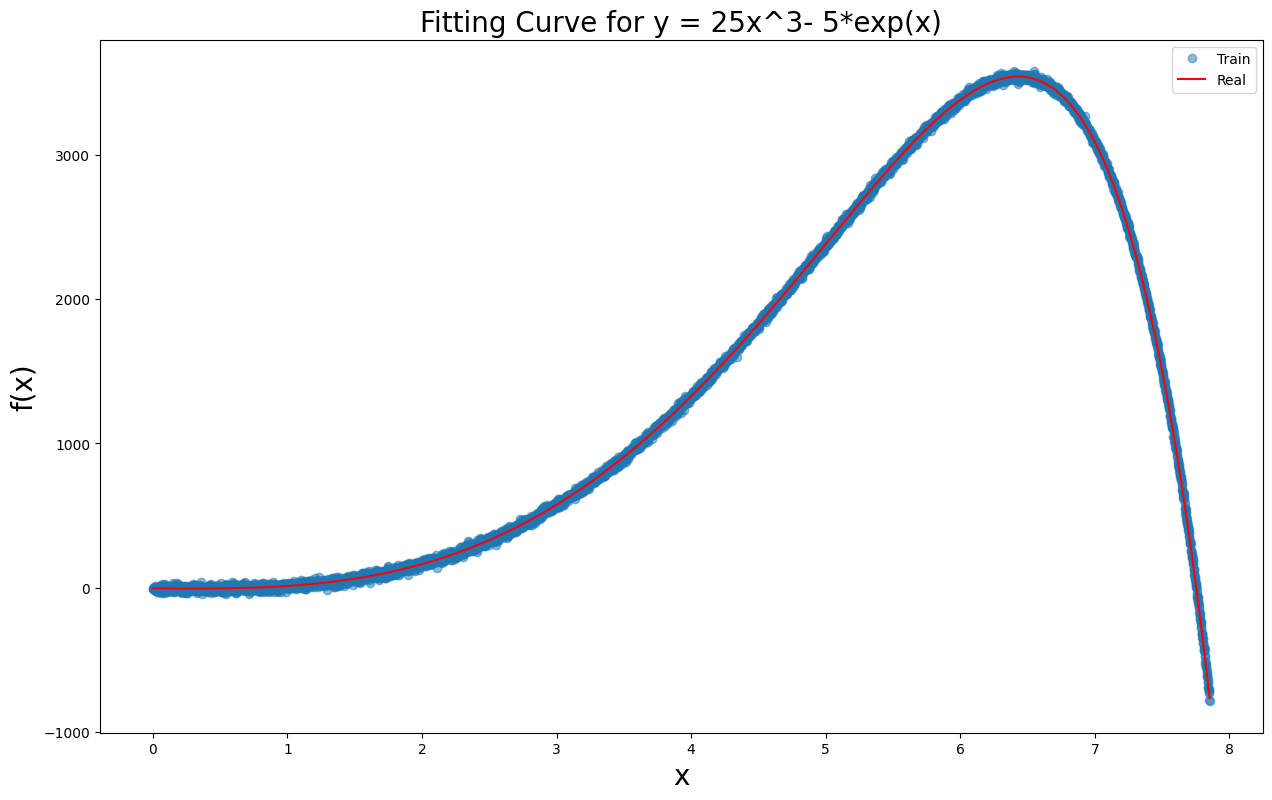

In [5]:
fig, ax1 = plt.subplots(figsize = (15, 9))
ax1.plot(x.detach().numpy(),y.detach().numpy(),'o',label='Train', alpha = 0.5)
ax1.plot(x_real.detach().numpy(), y_real.detach().numpy(), 'r', label = 'Real')
ax1.set_xlabel('x',color='black', fontsize = 20)
ax1.set_ylabel('f(x)',color='black', fontsize = 20)
ax1.tick_params(axis='y', color='black')
ax1.set_title('Fitting Curve for y = 25x^3- 5*exp(x)', fontsize = 20)
ax1.legend(loc = 'upper right')

In [6]:
indices=np.arange(5000)

In [7]:
x_train = x[indices]
y_train = y[indices]

In [8]:
'Convert our arrays to tensors and send them to our GPU'
x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
x_real = x_real.float().to(device)
y_real = y_real.float().to(device)
f_hat = torch.zeros(x_train.shape[0],1).to(device)

C:\Users\User\AppData\Local\Temp\ipykernel_15752\3787926796.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


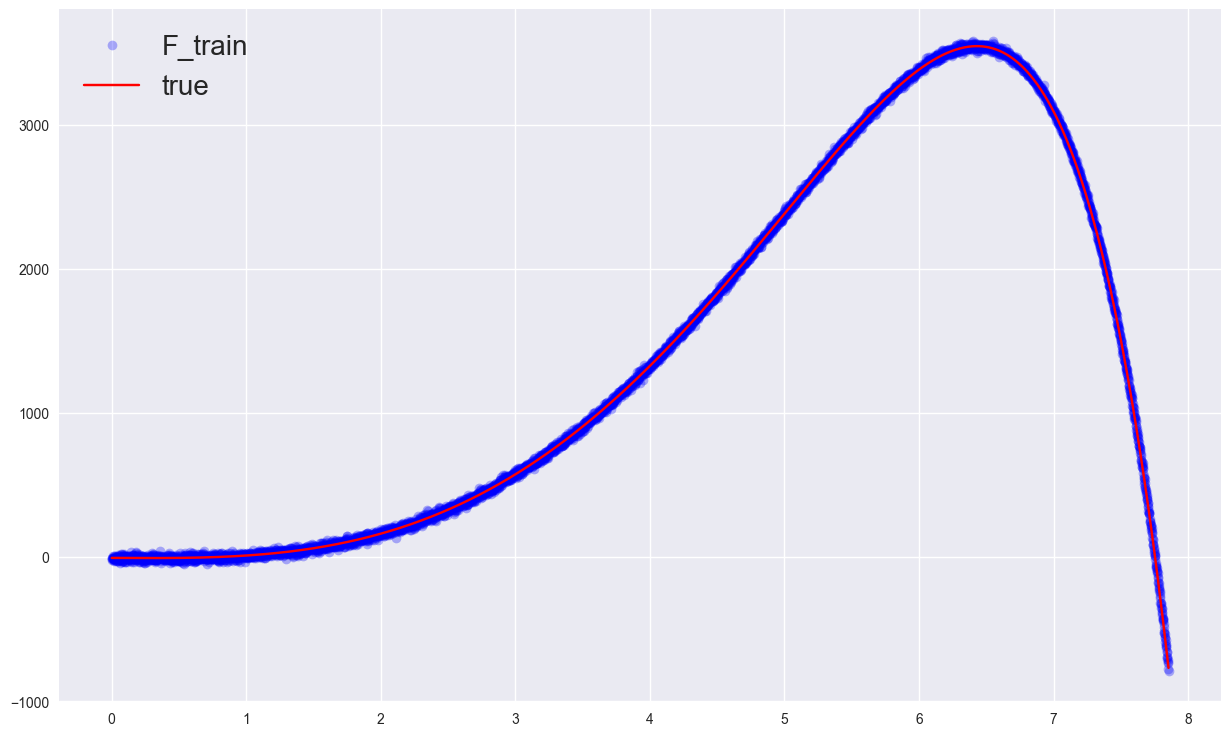

In [9]:
plt.figure(figsize = (15, 9))
plt.style.use('seaborn')
plt.plot(x_train.detach().cpu().numpy(), y_train.detach().cpu().numpy(), 'bo', alpha = 0.3, label = 'F_train')
plt.plot(x_real.detach().cpu().numpy(), y_real.detach().cpu().numpy(),'r-', label = 'true')
plt.legend(fontsize = 20)

In [10]:
layers = np.array([1, 120, 120, 120, 120, 120, 120, 120, 1]) #8 hidden layers

In [11]:
steps=50000
lr= 0.005

In [12]:
lambda1 = 24.
lambda2 = -5.5
lambda3 = 3.
# lambda4 = 3.
# lambda5 = 4.1

print("Te real 𝜆 = [", 25.0,-5.0,1.0, "]. Our initial guess will be 𝜆 _PINN= [", lambda1, lambda2, lambda3,"]")

Te real 𝜆 = [ 25.0 -5.0 1.0 ]. Our initial guess will be 𝜆 _PINN= [ 24.0 -5.5 3.0 ]


In [ ]:
PINN = FCN(layers)
       
PINN

'Neural Network Summary'
print(PINN)

params = list(PINN.dnn.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              tolerance_grad = 1e-7, 
                              tolerance_change = 1e-8, 
                              history_size = 15)

start_time = time.time()

optimizer.step(PINN.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

FCN(
  (activation): ReLU()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=120, bias=True)
    (2): Linear(in_features=120, out_features=120, bias=True)
    (3): Linear(in_features=120, out_features=120, bias=True)
    (4): Linear(in_features=120, out_features=120, bias=True)
    (5): Linear(in_features=120, out_features=120, bias=True)
    (6): Linear(in_features=120, out_features=120, bias=True)
    (7): Linear(in_features=120, out_features=1, bias=True)
  )
  (dnn): DNN(
    (activation): ReLU()
    (linears): ModuleList(
      (0): Linear(in_features=1, out_features=120, bias=True)
      (1): Linear(in_features=120, out_features=120, bias=True)
      (2): Linear(in_features=120, out_features=120, bias=True)
      (3): Linear(in_features=120, out_features=120, bias=True)
      (4): Linear(in_features=120, out_features=120, bias=True)
      (5): Linear(in_features=120, out

In [ ]:
def test_func(x, a, b, c):
    return a*x**3 + b*np.exp(c*x)

In [ ]:
a, b, c = PINN.lambda1.detach().cpu().numpy(), PINN.lambda2.detach().cpu().numpy(), PINN.lambda3.detach().cpu().numpy()#, PINN.lambda4.detach().cpu().numpy(), PINN.lambda5.detach().cpu().numpy()
a, b, c

In [ ]:
from scipy import optimize

x_fit = x.detach().cpu().numpy().reshape(5000, )
y_fit = y.detach().cpu().numpy().reshape(5000, )

params, params_covariance = optimize.curve_fit(test_func, x_fit, y_fit, p0=[lambda1,lambda2,lambda3])

print(params)

In [ ]:
plt.figure(figsize = (16, 10))
plt.plot(x.detach().cpu().numpy(), test_func(x.detach().cpu().numpy(), a, b, c), 'b', label = 'PINN Curve fit')
plt.plot(x.detach().cpu().numpy(), test_func(x.detach().cpu().numpy(), params[0], params[1], params[2]), 'g-', label = 'Scipy Curve fit')
plt.plot(x.detach().cpu().numpy(), f(x), 'r-', label = 'Ground Truth ')
plt.xlim([-0.2, 2.5*np.pi + 0.2])
plt.grid('True')
plt.legend(fontsize = 20)
plt.show()

In [ ]:
mse_pinn = 0
mse_scipy = 0
for i in range(500):
    mse_pinn += (f(x).detach().cpu().numpy()[i] - test_func(x.detach().cpu().numpy(), PINN.lambda1.detach().cpu().numpy(), PINN.lambda2.detach().cpu().numpy(), PINN.lambda3.detach().cpu().numpy())[i])**2
    mse_scipy += (f(x).detach().cpu().numpy()[i] - test_func(x.detach().cpu().numpy(), params[0], params[1], params[2])[i])**2
    

print("PINN MSE : ", mse_pinn)
print("Scipy MSE : ", mse_scipy)

In [ ]:
diff_pinn = f(x) - test_func(x.detach().cpu().numpy(), a, b, c)
diff_scipy = f(x) - test_func(x.detach().cpu().numpy(), params[0], params[1], params[2])

In [ ]:
plt.figure(figsize = (20, 9))
plt.plot(x, diff_pinn, 'r--', label = 'PINN Error')
plt.plot(x, diff_scipy, 'b--', label = 'Scipy Error')
plt.xlim([-0.2, 2.5*np.pi+0.2])
plt.grid(True)
plt.legend()
plt.show()